In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [9]:
def PlotParameters(model):
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:

            ax.set_xlabel("class: {0}".format(i))

            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [10]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

In [11]:
# Create and print the training dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [12]:
# Create and print the validation dataset

validation_dataset = dsets.MNIST(root='./data', download=True, transform=transforms.ToTensor())
print("Print the validation dataset:\n ", validation_dataset)

Print the validation dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


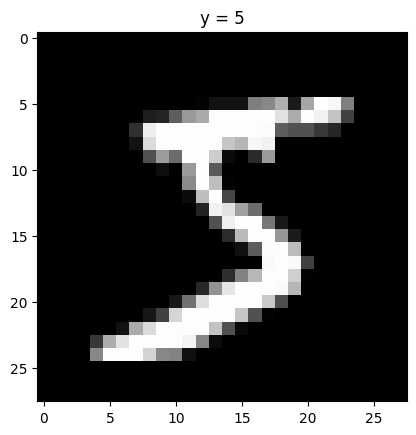

First Image and Label None


In [13]:
# Print the first image and label

print("First Image and Label", show_data(train_dataset[0]))

In [14]:
# Print the label

print("The label: ", train_dataset[3][1])

The label:  1


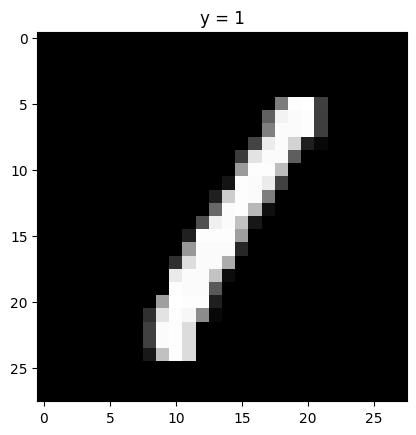

The image:  None


In [15]:
# Plot the image

print("The image: ", show_data(train_dataset[3]))

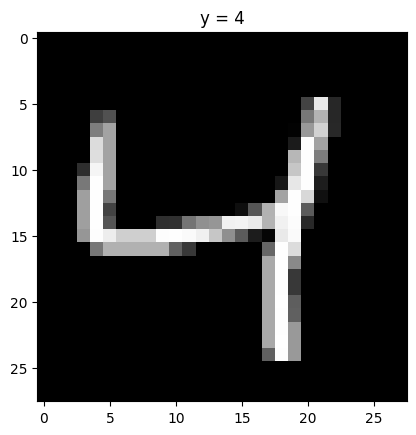

In [16]:
# Plot the image

show_data(train_dataset[2])

In [17]:
# Define softmax classifier class
# Inherits nn.Module which is the base class for all neural networks
class SoftMax(nn.Module):

    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        # Creates a layer of given input size and output size
        self.linear = nn.Linear(input_size, output_size)

    # Prediction
    def forward(self, x):
        # Runs the x value through the single layers defined above
        z = self.linear(x)
        return z

In [18]:
# Print the shape of the training dataset

train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [19]:
# Set input size and output size

input_dim = 28 * 28
output_dim = 10

In [20]:
# Create the model
# Input dim is 28*28 which is the image converted to a tensor
# Output dim is 10 because there are 10 possible digits the image can be
model = SoftMax(input_dim, output_dim)
print("Print the model:\n ", model)

Print the model:
  SoftMax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [21]:
# Print the parameters

print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([10, 784])
b:  torch.Size([10])


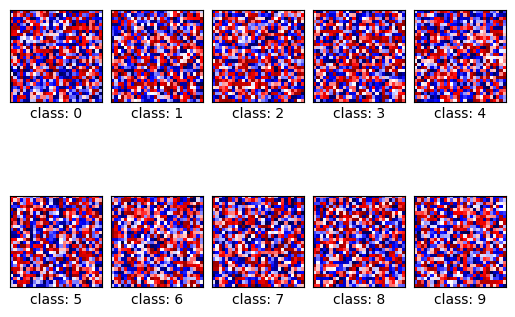

In [22]:
# Plot the model parameters for each class
# Since the model has not been trained yet the parameters look random

PlotParameters(model)

In [23]:
# First we get the X value of the first image
X = train_dataset[0][0]
# We can see the shape is 1 by 28 by 28, we need it to be flattened to 1 by 28 * 28 (784)
print(X.shape)
X = X.view(-1, 28*28)
print(X.shape)
# Now we can make a prediction, each class has a value, and the higher it is the more confident the model is that it is that digit
model(X)

torch.Size([1, 28, 28])
torch.Size([1, 784])


tensor([[-0.3709,  0.0467,  0.3321,  0.4275, -0.2031, -0.0957,  0.1945,  0.1173,
          0.1972,  0.0571]], grad_fn=<AddmmBackward0>)

In [24]:
# Define the learning rate, optimizer, criterion, and data loader

learning_rate = 0.1
# The optimizer will updates the model parameters using the learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# The criterion will measure the loss between the prediction and actual label values
# This is where the SoftMax occurs, it is built into the Criterion Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
# Created a training data loader so we can set the batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Created a validation data loader so we can set the batch size
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

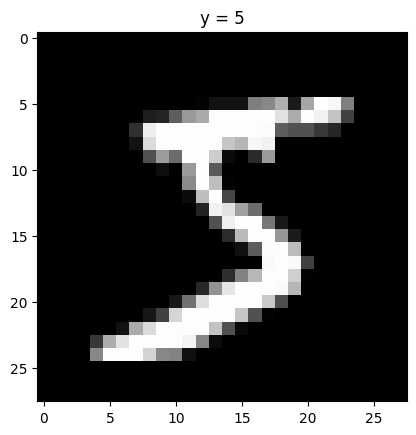

Output:  tensor([[-0.3709,  0.0467,  0.3321,  0.4275, -0.2031, -0.0957,  0.1945,  0.1173,
          0.1972,  0.0571]], grad_fn=<AddmmBackward0>)
Actual: tensor([5])


In [25]:
model_output = model(X)
actual = torch.tensor([train_dataset[0][1]])

show_data(train_dataset[0])
print("Output: ", model_output)
print("Actual:", actual)

In [26]:
criterion(model_output, actual)

tensor(2.4941, grad_fn=<NllLossBackward0>)

In [27]:
softmax = nn.Softmax(dim=1)
probability = softmax(model_output)
print(probability)

tensor([[0.0627, 0.0952, 0.1267, 0.1393, 0.0742, 0.0826, 0.1104, 0.1022, 0.1107,
         0.0962]], grad_fn=<SoftmaxBackward0>)


In [28]:
-1*torch.log(probability[0][actual])

tensor([2.4941], grad_fn=<MulBackward0>)

In [29]:
# Number of times we train our model useing the training data
n_epochs = 10
# Lists to keep track of loss and accuracy
loss_list = []
accuracy_list = []
# Size of the validation data
N_test = len(validation_dataset)

# Function to train the model based on number of epochs
def train_model(n_epochs):
    # Loops n_epochs times
    for epoch in range(n_epochs):
        # For each batch in the train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on the image tensor
            z = model(x.view(-1, 28 * 28))
            # Calculates loss between the model output and actual class
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()

        # Each epoch we check how the model performs with data it has not seen which is the validation data, we are not training here
        correct = 0
        # For each batch in the validation loader
        for x_test, y_test in validation_loader:
            # Makes prediction based on image tensor
            z = model(x_test.view(-1, 28 * 28))
            # Finds the class with the higest output
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual class and increments correct if it does
            correct += (yhat == y_test).sum().item()
        # Calculates the accuracy by dividing correct by size of validation dataset
        accuracy = correct / N_test
        # Keeps track loss
        loss_list.append(loss.data)
        # Keeps track of the accuracy
        accuracy_list.append(accuracy)

# Function call
train_model(n_epochs)

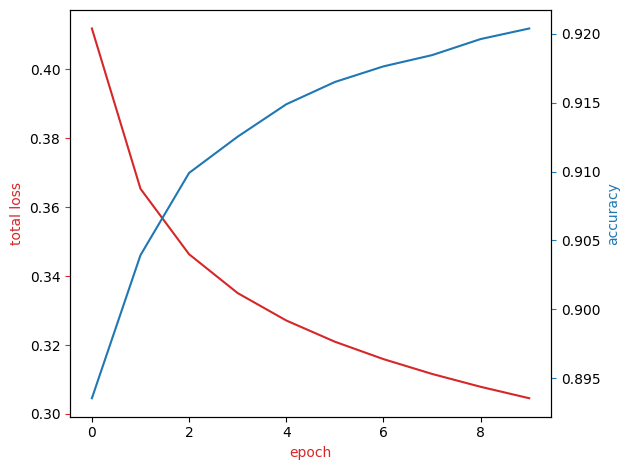

In [30]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

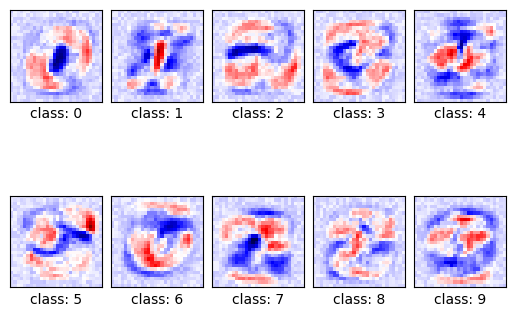

In [31]:
# Plot the parameters

PlotParameters(model)

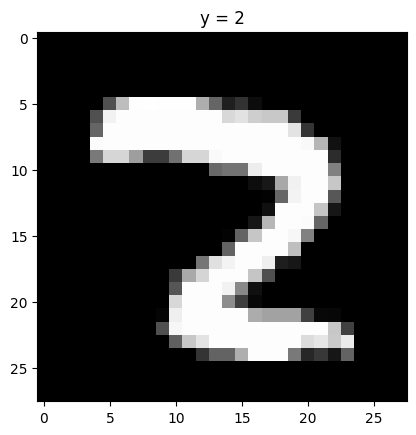

yhat: tensor([7])
probability of class  0.6682672500610352


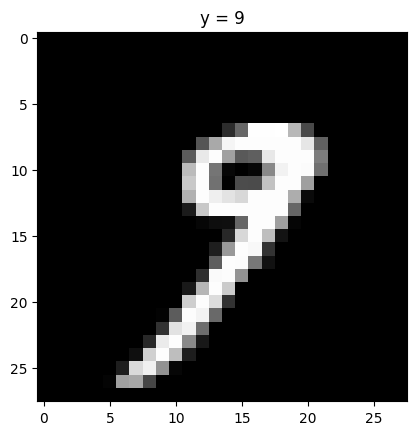

yhat: tensor([7])
probability of class  0.7075257301330566


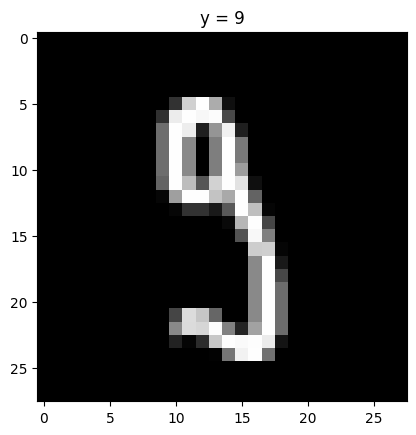

yhat: tensor([5])
probability of class  0.7371859550476074


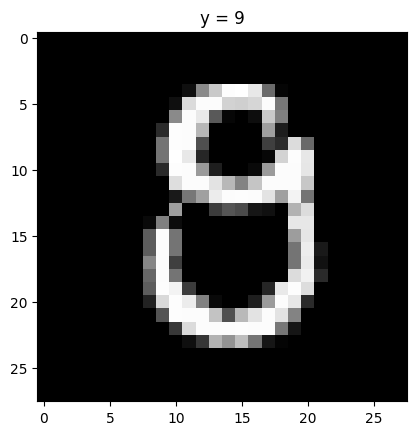

yhat: tensor([8])
probability of class  0.3636239171028137


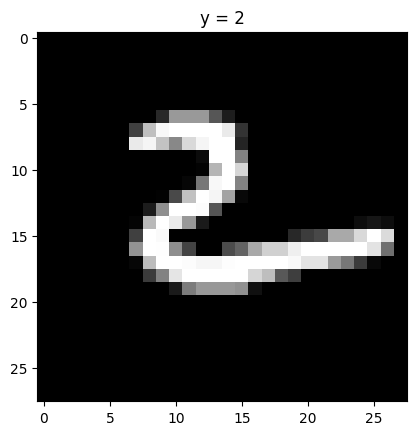

yhat: tensor([6])
probability of class  0.4978570342063904


In [32]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break

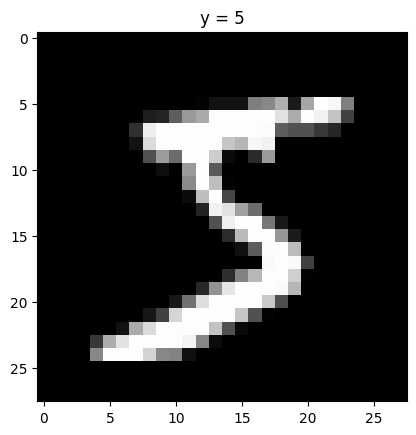

yhat: tensor([5])
probability of class  0.8598612546920776


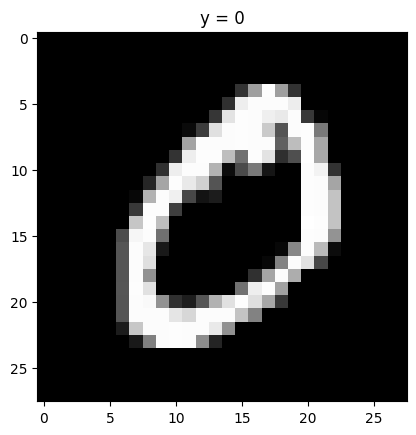

yhat: tensor([0])
probability of class  0.9997075200080872


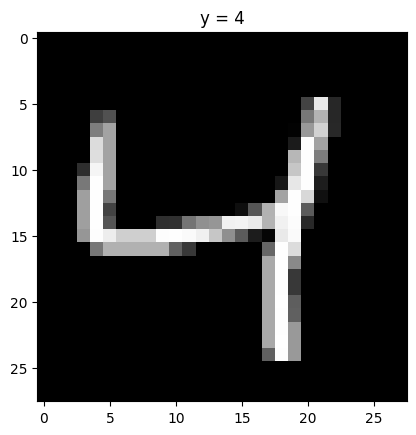

yhat: tensor([4])
probability of class  0.8700796961784363


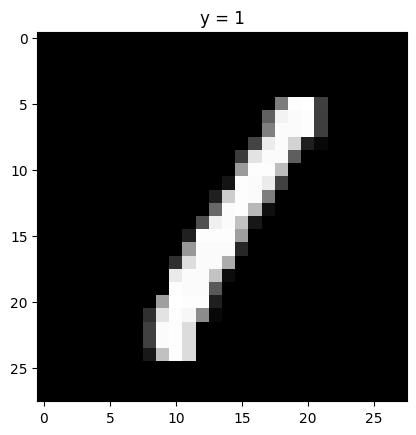

yhat: tensor([1])
probability of class  0.9646280407905579


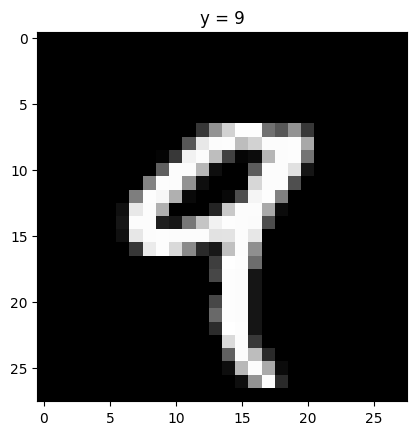

yhat: tensor([9])
probability of class  0.9260004162788391


In [33]:
# Plot the classified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 5:
        break